Original implementation of Contrastive-sc method
(https://github.com/ciortanmadalina/contrastive-sc)

In [1]:
import sys
sys.path.append("..")
import argparse
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn import metrics

import torch
import torch.nn as nn
import copy
import model
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import st_loss

import h5py
import scipy as sp
import scanpy.api as sc
from collections import Counter
import utils
import loop
import pickle
import os
import glob2
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/opt/conda/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
category = "balanced_data"
path = "../"
args = {
    "dims": [499, 256, 64, 32],
    "highly_genes": 500,
    'alpha': 0.001,
    'gamma': 0.001,
    'learning_rate': 0.0001,
    'update_epoch': 10,
    't_alpha': 1,
    'error': 0.001
}
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
args = objectview(args)

files = glob2.glob(f'../R/simulated_data/{category}/*.h5')
files = [f[len(f"{path}R/simulated_data/{category}/"):-3] for f in files]
files

['data_1c8',
 'data_-1c4',
 'data_-1c8',
 'data_0c4',
 'data_0c8',
 'data_0c16',
 'data_1.5c4',
 'data_1c32',
 'data_1c4',
 'data_1.5c8',
 'data_1.5c16',
 'data_0c32',
 'data_1.5c32',
 'data_-1c32',
 'data_-1c16',
 'data_1c16']

In [5]:
dr = pd.DataFrame(
    columns=["dataset", "dropout", "perc0", "nb_genes", "exp", "ari"])
for run in range(1):
    df = pd.DataFrame()

    print(df.shape)
    for dataset in files:
        print(f">>>>> Data {dataset}")

        data_mat = h5py.File(f"{path}R/simulated_data/{category}/{dataset}.h5", "r")
        for nb_genes in [100, 200, 500, 1000, 1500, 2500]:
            dp = data_mat['dropout'][0]
            X = np.array(data_mat['X'])
            Y = np.array(data_mat['Y'])
            perc_0 = np.where(X == 0)[0].shape[0] / (X.shape[0] * X.shape[1])
            print(f"Perc 0 {perc_0}")
            X = np.ceil(X).astype(np.int)
            count_X = X
            print(X.shape, count_X.shape)
            orig_X = X.copy()
            adata = sc.AnnData(X)
            adata.obs['Group'] = Y
            adata = utils.normalize(adata,
                                    copy=True,
                                    highly_genes=nb_genes,
                                    size_factors=True,
                                    normalize_input=True,
                                    logtrans_input=True)
            X = adata.X.astype(np.float32)
            Y = np.array(adata.obs["Group"])
            print(X.shape, count_X.shape)
            high_variable = np.array(adata.var.highly_variable.index,
                                     dtype=np.int)
            count_X = count_X[:, high_variable]
            size_factor = np.array(adata.obs.size_factors).reshape(
                -1, 1).astype(np.float32)
            cluster_number = int(max(Y) - min(Y) + 1)
            zeros = np.min(X, axis=0)
            pxt = PCA(2).fit_transform(X)
            dresults = {
                "dataset": dataset,
                "nclust": cluster_number,
                "original": utils.evaluate(X, Y, cluster_number)[1],
                "pca": utils.evaluate(pxt, Y, cluster_number)[1],
                "perc_0": perc_0
            }

            # 3 models
            st_results = []

            f = []
            nb_zeros = int(0.8 * nb_genes)
            print(f"nb_zeros = {nb_zeros}, nb_genes= {nb_genes}")
            nm = nb_genes
            r1 = loop.self_train_clustering(X,
                                            Y,
                                            cluster_number,
                                            args,
                                            augm_zeros=None,
                                            nb_zeros=nb_zeros,
                                            random=False,
                                            perc=0.1,
                                            augm_value=0,
                                            model_name="STClustering",
                                            epochs=500)
            f.append(r1['features'])
            st_results.append(r1)

            dresults[f"self_initial_{nm}"] = r1["aris_kmeans_representation"][
                -1]
            dresults[f"self_{nm}"] = r1["aris"][-1]
            dr.loc[dr.shape[0]] = [
                dataset, dp, perc_0, nb_genes, "method1-kmeans",
                r1["aris_kmeans_representation"][-1]
            ]
            dr.loc[dr.shape[0]] = [
                dataset, dp, perc_0, nb_genes, "method1-leiden",
                r1["ari_leiden_representation"]
            ]
            
            dr.loc[dr.shape[0]] = [
                dataset, dp, perc_0, nb_genes, "method2", r1["aris"][-1]
            ]
            print("ARI ", r1["aris_kmeans_representation"][-1], " leiden ",
                 r1["ari_leiden_representation"])
            df = df.append(dresults, ignore_index=True)
            print(dresults)
            all_res = dresults.copy()
            all_res["st"] = st_results
            if os.path.isdir(f"{path}output/{category}/") == False:
                os.makedirs(f"{path}output/{category}/",exist_ok=True)
            with open(
                    f"{path}output/{category}/results_{dataset}_{run}_input_size.pickle",
                    'wb') as handle:
                pickle.dump(dresults, handle, protocol=pickle.HIGHEST_PROTOCOL)

            with open(
                    f"{path}output/{category}/detailed_results_{dataset}_{run}_input_size.pickle",
                    'wb') as handle:
                pickle.dump(all_res, handle, protocol=pickle.HIGHEST_PROTOCOL)
            df.to_pickle(f"{path}output/pickle_results/{category}/{run}_input_size.pkl")
            dr.to_pickle(f"{path}output/pickle_results/{category}/summary_input_size.pkl")

(0, 0)
>>>>> Data data_1c8
Perc 0 0.4687938
(2000, 2500) (2000, 2500)
(2000, 99) (2000, 2500)
nb_zeros = 80, nb_genes= 100
..................................................ST Phase 1 ARI 0.33942, NMI 0.37159
accuracy 0.587, ARI 0.35352, NMI 0.38213
ARI  0.33942  leiden  0.27437995590350495
{'dataset': 'data_1c8', 'nclust': 8, 'original': 0.0675, 'pca': 0.06371, 'perc_0': 0.4687938, 'self_initial_100': 0.33942, 'self_100': 0.35352}
Perc 0 0.4687938
(2000, 2500) (2000, 2500)
(2000, 199) (2000, 2500)
nb_zeros = 160, nb_genes= 200
..................................................ST Phase 1 ARI 0.53957, NMI 0.60395
accuracy 0.748, ARI 0.58654, NMI 0.5947
ARI  0.53957  leiden  0.5045602506178465
{'dataset': 'data_1c8', 'nclust': 8, 'original': 0.15727, 'pca': 0.07459, 'perc_0': 0.4687938, 'self_initial_200': 0.53957, 'self_200': 0.58654}
Perc 0 0.4687938
(2000, 2500) (2000, 2500)
(2000, 499) (2000, 2500)
nb_zeros = 400, nb_genes= 500
..................................................ST Pha

(1000, 499) (1000, 2500)
nb_zeros = 400, nb_genes= 500
..................................................ST Phase 1 ARI 0.95779, NMI 0.931
accuracy 0.986, ARI 0.9629, NMI 0.938
ARI  0.95779  leiden  0.8803605777160852
{'dataset': 'data_0c4', 'nclust': 4, 'original': 0.93033, 'pca': 0.72586, 'perc_0': 0.3422924, 'self_initial_500': 0.95779, 'self_500': 0.9629}
Perc 0 0.3422924
(1000, 2500) (1000, 2500)
(1000, 999) (1000, 2500)
nb_zeros = 800, nb_genes= 1000
..................................................ST Phase 1 ARI 0.89538, NMI 0.85497
accuracy 0.978, ARI 0.94356, NMI 0.91138
ARI  0.89538  leiden  0.6067506221188573
{'dataset': 'data_0c4', 'nclust': 4, 'original': 0.92573, 'pca': 0.64385, 'perc_0': 0.3422924, 'self_initial_1000': 0.89538, 'self_1000': 0.94356}
Perc 0 0.3422924
(1000, 2500) (1000, 2500)
(1000, 1500) (1000, 2500)
nb_zeros = 1200, nb_genes= 1500
..................................................ST Phase 1 ARI 0.88941, NMI 0.85079
accuracy 0.981, ARI 0.95105, NMI 0.92

(1000, 1500) (1000, 2500)
nb_zeros = 1200, nb_genes= 1500
..................................................ST Phase 1 ARI 0.03157, NMI 0.04307
accuracy 0.334, ARI 0.03692, NMI 0.04636
ARI  0.03157  leiden  0.03541657436936327
{'dataset': 'data_1.5c4', 'nclust': 4, 'original': 0.02439, 'pca': 0.13561, 'perc_0': 0.5077412, 'self_initial_1500': 0.03157, 'self_1500': 0.03692}
Perc 0 0.5077412
(1000, 2500) (1000, 2500)
(1000, 2471) (1000, 2500)
nb_zeros = 2000, nb_genes= 2500
..................................................ST Phase 1 ARI 0.00936, NMI 0.01333
accuracy 0.297, ARI 0.00919, NMI 0.01411
ARI  0.00936  leiden  0.028212492618531388
{'dataset': 'data_1.5c4', 'nclust': 4, 'original': 0.00317, 'pca': 0.07846, 'perc_0': 0.5077412, 'self_initial_2500': 0.00936, 'self_2500': 0.00919}
>>>>> Data data_1c32
Perc 0 0.46621855
(8000, 2500) (8000, 2500)
(8000, 100) (8000, 2500)
nb_zeros = 80, nb_genes= 100
..................................................ST Phase 1 ARI 0.01655, NMI 0.05533

Perc 0 0.5137823
(4000, 2500) (4000, 2500)
(4000, 99) (4000, 2500)
nb_zeros = 80, nb_genes= 100
..................................................ST Phase 1 ARI 0.0991, NMI 0.15138
accuracy 0.2605, ARI 0.11915, NMI 0.16522
ARI  0.0991  leiden  0.08480368309855472
{'dataset': 'data_1.5c16', 'nclust': 16, 'original': 0.00113, 'pca': 0.00691, 'perc_0': 0.5137823, 'self_initial_100': 0.0991, 'self_100': 0.11915}
Perc 0 0.5137823
(4000, 2500) (4000, 2500)
(4000, 199) (4000, 2500)
nb_zeros = 160, nb_genes= 200
..................................................ST Phase 1 ARI 0.13207, NMI 0.20687
accuracy 0.29225, ARI 0.1298, NMI 0.20053
ARI  0.13207  leiden  0.110741669035666
{'dataset': 'data_1.5c16', 'nclust': 16, 'original': 0.00279, 'pca': 0.00691, 'perc_0': 0.5137823, 'self_initial_200': 0.13207, 'self_200': 0.1298}
Perc 0 0.5137823
(4000, 2500) (4000, 2500)
(4000, 499) (4000, 2500)
nb_zeros = 400, nb_genes= 500
..................................................ST Phase 1 ARI 0.0714, NMI

Perc 0 0.2942935
(8000, 2500) (8000, 2500)
(8000, 500) (8000, 2500)
nb_zeros = 400, nb_genes= 500
..................................................ST Phase 1 ARI 0.29085, NMI 0.42748
accuracy 0.471, ARI 0.25366, NMI 0.41796
ARI  0.29085  leiden  0.2492658319225237
{'dataset': 'data_-1c32', 'nclust': 32, 'original': 0.011, 'pca': 0.01559, 'perc_0': 0.2942935, 'self_initial_500': 0.29085, 'self_500': 0.25366}
Perc 0 0.2942935
(8000, 2500) (8000, 2500)
(8000, 999) (8000, 2500)
nb_zeros = 800, nb_genes= 1000
..................................................ST Phase 1 ARI 0.4971, NMI 0.72683
accuracy 0.838, ARI 0.74141, NMI 0.79892
ARI  0.4971  leiden  0.7265160729680824
{'dataset': 'data_-1c32', 'nclust': 32, 'original': 0.03241, 'pca': 0.02129, 'perc_0': 0.2942935, 'self_initial_1000': 0.4971, 'self_1000': 0.74141}
Perc 0 0.2942935
(8000, 2500) (8000, 2500)
(8000, 1500) (8000, 2500)
nb_zeros = 1200, nb_genes= 1500
..................................................ST Phase 1 ARI 0.72689,

In [3]:
dr = pd.read_pickle(f"{path}output/pickle_results/{category}/summary_input_size.pkl")

In [6]:
dr

,dataset,dropout,perc0,nb_genes,exp,ari
0,data_1c8,0.307152,0.468794,100,method1-kmeans,0.339420
1,data_1c8,0.307152,0.468794,100,method1-leiden,0.274380
2,data_1c8,0.307152,0.468794,100,method2,0.353520
3,data_1c8,0.307152,0.468794,200,method1-kmeans,0.539570
4,data_1c8,0.307152,0.468794,200,method1-leiden,0.504560
...,...,...,...,...,...,...
283,data_1c16,0.295128,0.448426,1500,method1-leiden,0.246189
284,data_1c16,0.295128,0.448426,1500,method2,0.324520
285,data_1c16,0.295128,0.448426,2500,method1-kmeans,0.187420
286,data_1c16,0.295128,0.448426,2500,method1-leiden,0.201682


In [7]:
dr = dr.rename(columns = {"nb_genes": "Nb input genes"})

exp_names = {
    'method1-kmeans': "Baseline + KMeans", 
    'method1-leiden': "Baseline + Leiden", 
    'method2': "Cluster network"
}

dr["exp"] = dr["exp"].apply(lambda x: exp_names[x] if x in exp_names else x  )

# dr.to_pickle(f"{path}output/pickle_results/{category}/real_data_input_size.pkl")

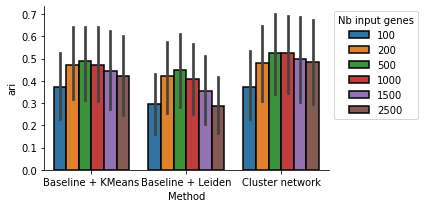

In [9]:
import seaborn as sns

plt.figure(figsize=(6, 3))
ax = plt.subplot(111)
sns.barplot(
    hue="Nb input genes",
    y="ari",
    x="exp",
    data=dr,
    ax=ax,
    edgecolor='black',
    linewidth=1.5,
)
sns.despine()
plt.legend(title= "Nb input genes",bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.xlabel("Method")
plt.savefig(f"{path}diagrams/balanced_input_size.pdf", bbox_inches='tight')